## Pipelines

- The main reason for this is that GBMs has no good way to introduce sample weights
- To add GBMs with resampling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill as pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.utils import resample
import sklearn.metrics as metrics

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Read the relevant pieces
- X_train, X_test, y_train, y_test
- Feature transformer functions

In [2]:
X_train = pd.read_pickle("../../grab-ai-safety-data/X_train_transformed.pickle")
X_test = pd.read_pickle("../../grab-ai-safety-data/X_test.pickle")
y_test = pd.read_pickle("../../grab-ai-safety-data/y_test.pickle")
y_train = pd.read_pickle("../../grab-ai-safety-data/y_train.pickle")

clean_columns = pickle.load(open("../outputs/clean_columns.pickle", "rb"))
create_windows = pickle.load(open("../outputs/create_windows.pickle", "rb"))
extract_features = pickle.load(open("../outputs/extract_features.pickle", "rb"))
min_boundary = pickle.load(open("../outputs/min_boundary.pickle", "rb"))
max_boundary = pickle.load(open("../outputs/max_boundary.pickle", "rb"))

## Apply transformations to test sets

In [3]:
X_test = (
    X_test.pipe(
        clean_columns
    ).pipe(
        create_windows
    ).pipe(
        extract_features
    )
)

In [4]:
y_train = y_train.drop_duplicates(
    subset="bookingID", 
    keep="first"
).set_index("bookingID")["label"]
y_test = y_test.drop_duplicates(
    subset="bookingID", 
    keep="first"
).set_index("bookingID")["label"]

## Resampling data
- Find a way to take care of class imbalance

In [5]:
df_grouped = pd.concat([X_train, y_train], axis=1)
df_majority = df_grouped[df_grouped["label"] == 0]
df_minority = df_grouped[df_grouped["label"] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.count()[0],
    random_state=42
)

df_grouped = pd.concat(
    [df_majority, df_minority_upsampled]
)

X_train = df_grouped.iloc[:, :-1]
y_train = df_grouped.iloc[:, -1]

## Model Pipelines
- Define pipelines
    - GBM
    - Logisitc Regresion
    - Logistic Regression with PCA
    - Random Forests
    - Random Forests with PCA
- Define GS grids
- To add in grid search parameters

In [6]:
jobs = -1
pipe_gbm = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]
)

pipe_lr = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", LogisticRegression(
            random_state=42, 
            penalty="l2", 
            max_iter=4000)
        )
    ]
)

pipe_lr_pca = Pipeline(
    [
        ("scl", StandardScaler()),
        ("pca", PCA(n_components=2)),
        ("clf", LogisticRegression( 
            random_state=42, 
            penalty="l2",
            max_iter=4000
        ))
    ]
)

pipe_rf = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", RandomForestClassifier(
            random_state=42, 
            class_weight="balanced")
        )
    ]
)

pipe_rf_pca = Pipeline(
    [
        ("scl", StandardScaler()),
        ("pca", PCA(n_components=2)),
        ("clf", RandomForestClassifier(
            random_state=42, 
            class_weight="balanced"))
    ]
)

In [7]:
grid_params_gbm = [
    {
        "clf__learning_rate": [0.1],
        #"clf__min_samples_split": np.linspace(0.1, 0.5, 2),
        #"clf__min_samples_leaf": np.linspace(0.1, 0.5, 2),
        "clf__max_depth":[3,5,8],
        "clf__max_features":["log2","sqrt"],
        "clf__n_estimators":[100]
    }
]

grid_params_lr = [
   {
       "clf__solver" : ["lbfgs", "sag", "saga"],
        "clf__C" : np.logspace(-3,3,7),
   }
]

grid_params_rf = { 
    "clf__n_estimators" : [50, 100],
    "clf__max_features" : [0.5, 0.75],
    "clf__max_depth" : [3, 5, 8]
}


In [8]:
gs_gbm = GridSearchCV(
    estimator=pipe_gbm,
    param_grid=grid_params_gbm,
    scoring="roc_auc",
    cv=10,
    n_jobs=jobs
)

gs_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=grid_params_lr,
    scoring="roc_auc",
    cv=10
) 

gs_lr_pca = GridSearchCV(
    estimator=pipe_lr_pca,
    param_grid=grid_params_lr,
    scoring="roc_auc",
    cv=10
)

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=grid_params_rf,
    scoring="roc_auc",
    cv=10, 
    n_jobs=jobs
)

gs_rf_pca = GridSearchCV(
    estimator=pipe_rf_pca,
    param_grid=grid_params_rf,
    scoring="roc_auc",
    cv=10, 
    n_jobs=jobs
)

In [9]:
grids = [
    gs_gbm, 
    gs_lr, 
    gs_lr_pca, 
    gs_rf, 
    gs_rf_pca
]

grid_dict = {
    0: "Gradient Boosted Machine",
    1: "Logistic Regression", 
    2: "Logistic Regression w/PCA", 
    3: "Random Forest", 
    4: "Random Forest w/PCA", 
}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])

    gs.fit(X_train, y_train)

    print('Best params: %s' % gs.best_params_)
    print('Best training accuracy: %.3f' % gs.best_score_)

    y_pred = gs.predict(X_test)
    y_prob = gs.predict_proba(X_test)[:, 1]

    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print("ROC_AUC score for best params: %.3f" % roc_auc_score(y_test, y_prob))

    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Gradient Boosted Machine
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__max_features': 'log2', 'clf__n_estimators': 100}
Best training accuracy: 0.928
Test set accuracy score for best params: 0.733 
ROC_AUC score for best params: 0.710

Estimator: Logistic Regression
Best params: {'clf__C': 10.0, 'clf__solver': 'lbfgs'}
Best training accuracy: 0.721
Test set accuracy score for best params: 0.672 
ROC_AUC score for best params: 0.718

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 10.0, 'clf__solver': 'saga'}
Best training accuracy: 0.635
Test set accuracy score for best params: 0.662 
ROC_AUC score for best params: 0.646

Estimator: Random Forest
Best params: {'clf__max_depth': 8, 'clf__max_features': 0.75, 'clf__n_estimators': 100}
Best training accuracy: 0.789
Test set accuracy score for best params: 0.694 
ROC_AUC score for best params: 0.724

Estimator: Random Forest w/PCA
Best params: {'clf__max_depth

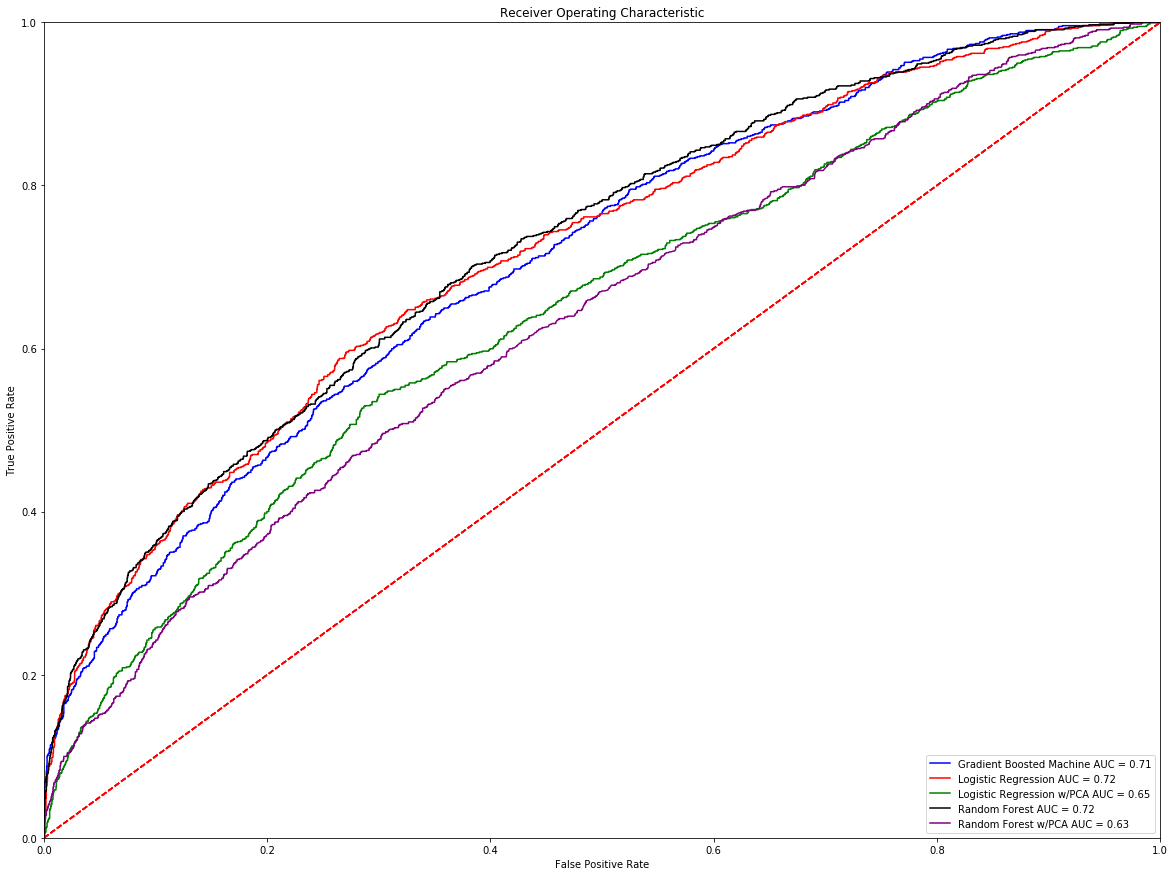

In [10]:
color_dict = {
    0: "blue",
    1: "red", 
    2: "green", 
    3: "black", 
    4: "purple", 
}
plt.figure(figsize=(20, 15))
for idx, gs in enumerate(grids):
    probs = gs.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(
        fpr, 
        tpr, 
        color=color_dict[idx], 
        label = '%s AUC = %0.2f' % (grid_dict[idx], roc_auc)
    )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

## Plot feature importances

In [11]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced").fit(X_train, y_train)

feature_importances = pd.DataFrame(
    rf.feature_importances_,
    index = X_train.columns,
    columns=['importance']
).sort_values(
    'importance', 
    ascending=False
)

<BarContainer object of 21 artists>

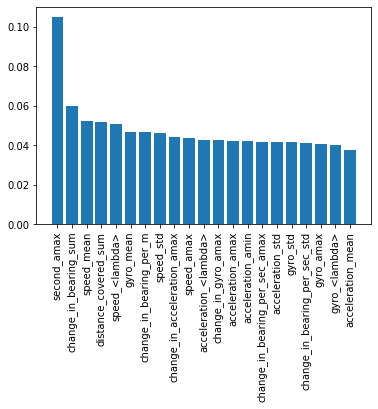

In [12]:
plt.xticks(rotation=90)
plt.bar(feature_importances.index, feature_importances["importance"])

## Cross validation
- Check if there is data leakage?
- A sudden jump to 90% accuracy seems dubious

In [13]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cross_val_score(
    pipe_rf, 
    X_train, 
    y_train, 
    cv=cv
)

array([0.90649729, 0.90712203, 0.91003748, 0.90733028, 0.90108288,
       0.9092045 , 0.91253644, 0.908788  , 0.90712203, 0.91295294])